In [2]:
%matplotlib inline

ImageContainer object
=====================

This tutorial shows how to use {class}`squidpy.im.ImageContainer` to interact with image structured data.

The ImageContainer is the central object in Squidpy containing the high resolution images.
It wraps {class}`xarray.Dataset` and provides different cropping, processing, and feature extraction functions.


In [3]:
import numpy as np

import squidpy as sq

Initialize ImageContainer
-------------------------
The {class}`squidpy.im.ImageContainer` constructor can read in memory
{class}`numpy.ndarray`/{class}`xarray.DataArray` or on-disk image files.
The `ImageContainer` can store multiple image layers (for example an image and a matching segmentation mask).

Images are expected to have at least a `x` and `y` dimension, with optional `channel` and `z` dimensions.
Here, we will focus on 2D images without at `z` dimension.

Most important arguments upon initialization are:

  - `img` - the image.
  - `layer` - the name of the image layer.
  - `dims` - to specify the dimensions names of `img`.
  - `lazy` - set to True to allow lazy computations.
  - `scale` - set this to the scaling factor between the image and the coordinates saved.

Let us see these arguments in action with a toy example.

In [4]:
arr = np.ones((100, 100, 3))
arr[40:60, 40:60] = [0, 0.7, 1]

print(arr.shape)
img = sq.im.ImageContainer(arr, layer="img1")
img

(100, 100, 3)


ImageContainer[shape=(100, 100), layers=['img1']]

`img` now contains one layer, `img1`. The default value of `dims` expects the image to have dimensions
``y, x, channels`` or ``y, x, z, channels``.
If the image has different dimensions, you can specify another strategy or a tuple of dimension names:

In [5]:
arr1 = arr.transpose(2, 0, 1)
print(arr1.shape)
img = sq.im.ImageContainer(arr1, dims=("channels", "y", "x"), layer="img1")
img

(3, 100, 100)


ImageContainer[shape=(100, 100), layers=['img1']]

Add layers to ImageContainer
----------------------------
You can add image layers into the ImageContainer using {meth}`squidpy.im.ImageContainer.add_img`.

The new layer has to share `x`, `y` (and `z`) dimensions with the already existing image.
It can have different channel dimensions. This is useful for add e.g., segmentation masks.

By default, unique layer and channel dimension names are chosen, you can specify them using the
`layer` and `dims` arguments.

In [6]:
arr_seg = np.zeros((100, 100))
arr_seg[40:60, 40:60] = 1

img.add_img(arr_seg, layer="seg1")
img

ImageContainer[shape=(100, 100), layers=['img1', 'seg1']]

For convenience, you can also assign image layers directly using the new layer name:

In [7]:
img["seg2"] = arr_seg
img

ImageContainer[shape=(100, 100), layers=['img1', 'seg1', 'seg2']]

You can get a list of layers contained in an ImageContainer, and access specific
image-structured arrays using their names:

In [8]:
print(list(img))
img["img1"]

['img1', 'seg1', 'seg2']


<xarray.DataArray 'img1' (y: 100, x: 100, z: 1, channels: 3)>
array([[[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        ...,

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]],


       [[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]],
...
        [[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]],


       [[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        ...,

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]]])
Coordinates:
  * z        (z) <U1 '0'
Dimensions without coordinates: y, x, channels

Renaming of image layers is also possible using {meth}`squidpy.im.ImageContainer.rename`:

In [9]:
img.rename("seg2", "new-name")

ImageContainer[shape=(100, 100), layers=['img1', 'new-name', 'seg1']]

Visualization
-------------
Use {meth}`squidpy.im.ImageContainer.show` to visualize (small) images statically.
See {doc}`./../examples/image/compute_show.ipynb` for more details.

For large images and for interactive visualization of {class}`squidpy.im.ImageContainer` together with
spatial 'omics data, we recommend using {meth}`squidpy.im.ImageContainer.interactive`, which uses Napari.
See `Interactive visualization with Napari <../tutorials/tutorial_napari.ipynb>`_ for more details.

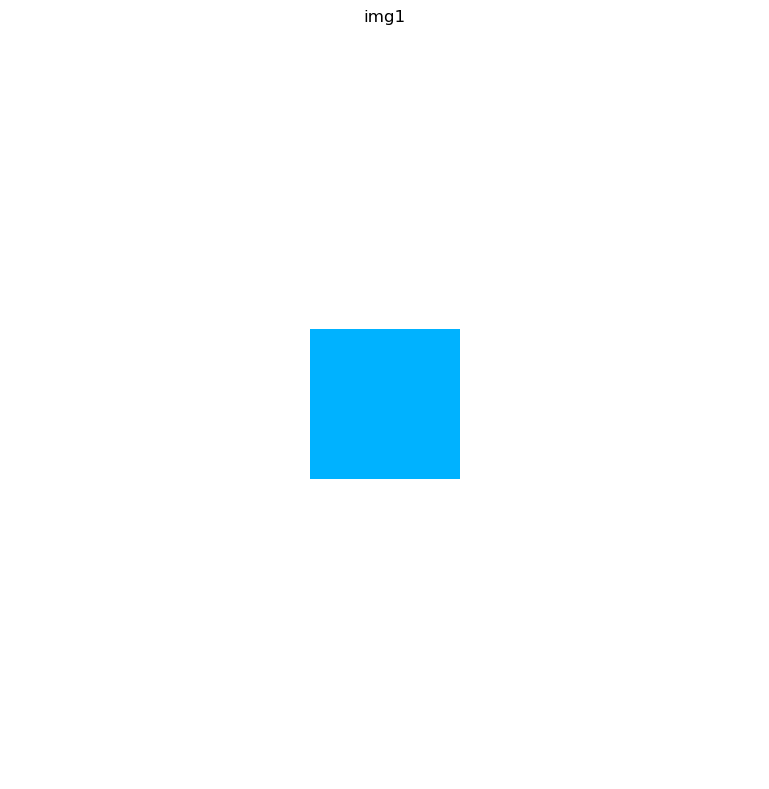

In [10]:
img.show(layer="img1")

Crop and scale images
---------------------
Images can be cropped and scaled using {meth}`squidpy.im.ImageContainer.crop_corner` and
{meth}`squidpy.im.ImageContainer.crop_center`.
See {doc}`./../examples/image/compute_crops.ipynb` for more details.

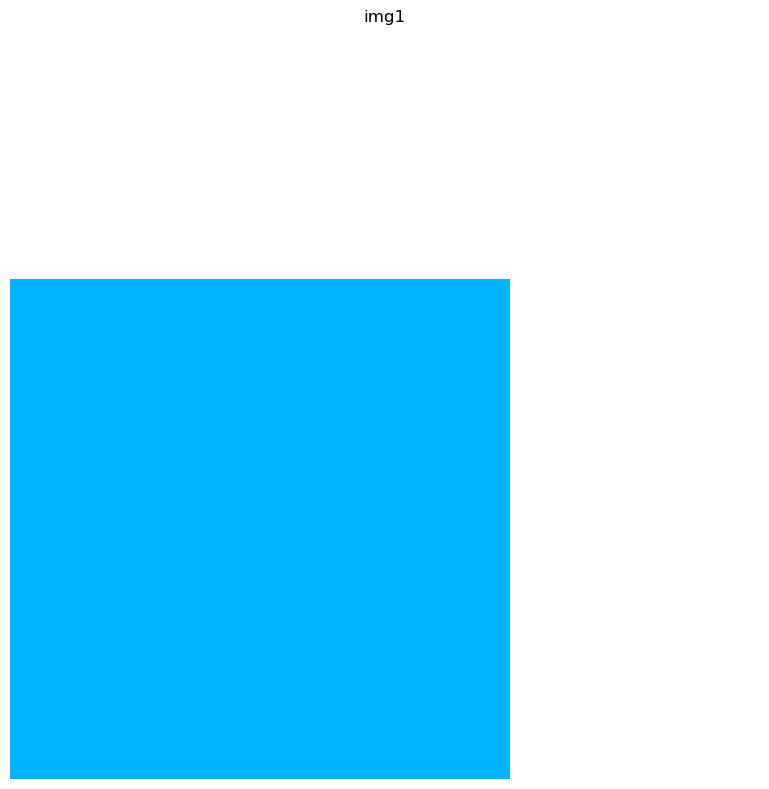

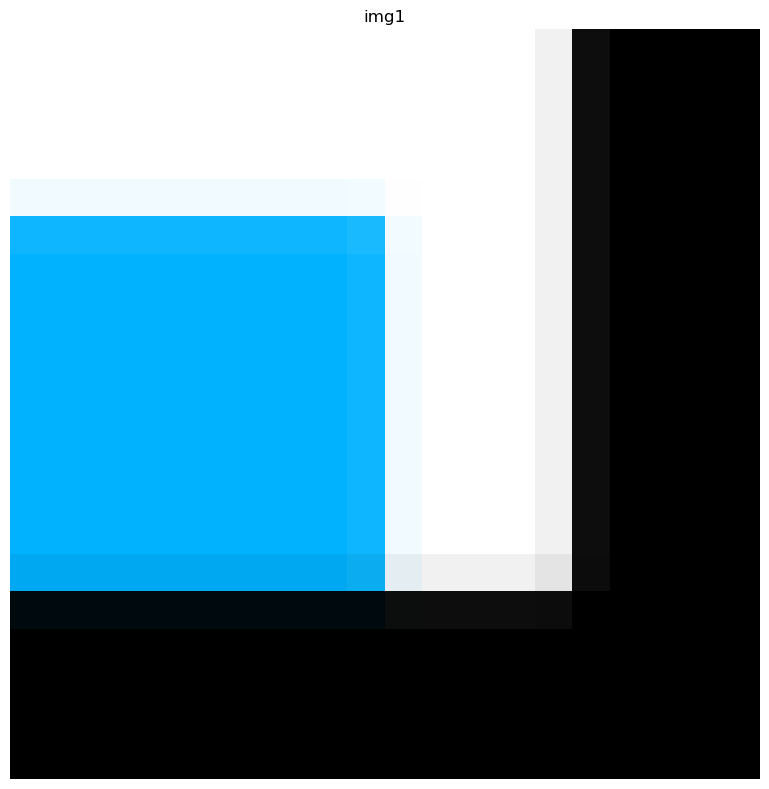

In [11]:
crop1 = img.crop_corner(30, 40, size=(30, 30), scale=1)
crop1.show(layer="img1")

crop2 = crop1.crop_corner(0, 0, size=(40, 40), scale=0.5)
crop2.show(layer="img1")

Internally, the `ImageContainer` keeps track of the crop coordinates in the dataset attributes.
This enables mapping from cropped `ImageContainers` to observations in `adata` for interactive
visualization and feature extraction.

Using {meth}`squidpy.im.ImageContainer.uncrop`, we can reconstruct the original image.
Even when chaining multiple calls to ``crop``, ``uncrop`` correctly places the crop in the image.
Note that ``uncrop`` only undoes the cropping, not the scaling.

{'coords': CropCoords(x0=40, y0=30, x1=70, y1=60), 'padding': CropPadding(x_pre=0, x_post=0, y_pre=0, y_post=0), 'scale': 1.0, 'mask_circle': False}
{'coords': CropCoords(x0=20.0, y0=15.0, x1=35.0, y1=30.0), 'padding': CropPadding(x_pre=0.0, x_post=5.0, y_pre=0.0, y_post=5.0), 'scale': 0.5, 'mask_circle': False}


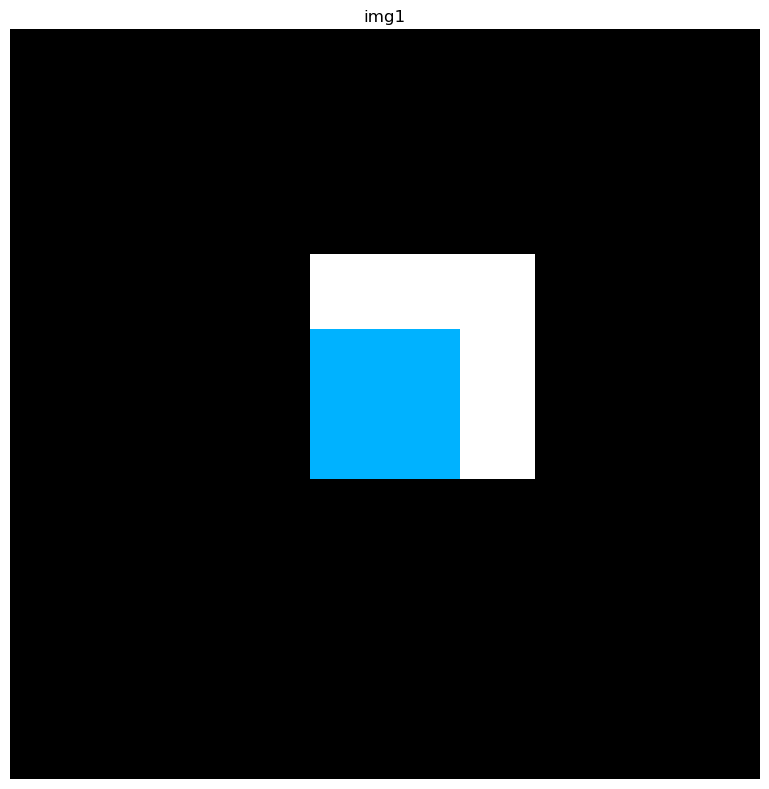

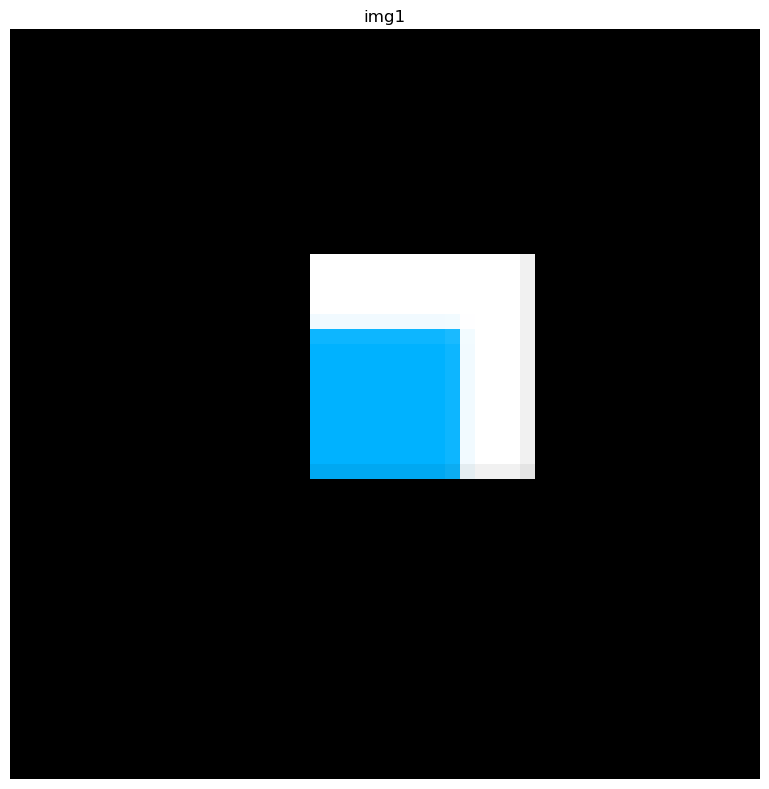

In [12]:
print(crop1.data.attrs)
print(crop2.data.attrs)

sq.im.ImageContainer.uncrop([crop1], shape=img.shape).show(layer="img1")
sq.im.ImageContainer.uncrop([crop2], shape=(50, 50)).show(layer="img1")

After cropping the ImageContainer, you can subset the associated `adata` to the cropped image using
{meth}`squidpy.im.ImageContainer.subset`. See {doc}`./../examples/image/compute_crops.ipynb` for an example.

Processing images and extracting features
-----------------------------------------
The main purpose of ImageContainer is to allow efficient image processing, segmentation and features extraction.

For details on each of these steps, have a look a the following examples using the high-level API:

  - {doc}`./../examples/image/compute_process_hires.ipynb` for {func}`sq.im.process`.
  - {doc}`./../examples/image/compute_segment_fluo.ipynb` for {func}`sq.im.segment`.
  - {doc}`./../examples/image/compute_features.ipynb` for {func}`sq.im.extract_features`.

These functions are build to be general and flexible. All of them allow you to pass custom processing and
feature extraction functions for easy use of external packages with Squidpy.

For even more control, you can also use low-level functions provided by `ImageContainer`:

  - {meth}`sq.im.ImageContainer.apply` for custom processing functions that should be applied to a
    specific image layer.
  - {meth}`sq.im.ImageContainner.feature_custom` for extracting features.

There are two generators, that allow you to iterate over a sequence of image crops and apply
processing functions to smaller crops (e.g. to allow parallelization or processing images
that won't fit in memory:

  - {meth}`sq.im.ImageContainer.generate_equal_crops`, for evenly decomposing the image into equally sized crops.
  - {meth}`sq.im.ImageContainer.generate_spot_crops`, for extracting image crops for each observation in the
    associated `adata`.

Internal representation of images
---------------------------------
Internally, the images are represented in a {class}`xarray.Dataset`. You can access this dataset using
{attr}`img.data`.

In [13]:
img.data

<xarray.Dataset>
Dimensions:   (z: 1, y: 100, x: 100, channels: 3, channels_0: 1, channels_1: 1)
Coordinates:
  * z         (z) <U1 '0'
Dimensions without coordinates: y, x, channels, channels_0, channels_1
Data variables:
    img1      (y, x, z, channels) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    seg1      (y, x, z, channels_0) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    new-name  (y, x, z, channels_1) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    coords:       CropCoords(x0=0, y0=0, x1=0, y1=0)
    padding:      CropPadding(x_pre=0, x_post=0, y_pre=0, y_post=0)
    scale:        1.0
    mask_circle:  False

Whenever possible, images are represented as lazy {mod}`dask` arrays.
This allows lazy computations, which only load and compute the data when it is required.

Let us load an on-disk image that is provided by the {mod}`squidpy.datasets` module:
By default, the `lazy` argument is `True`, therefore resulting in a {class}`dask.array.Array`.

In [14]:
img_on_disk = sq.datasets.visium_hne_image()
print(type(img_on_disk["image"].data))

100%|██████████| 380M/380M [00:56<00:00, 7.05MB/s] 

<class 'dask.array.core.Array'>


We can use {meth}`squidpy.im.ImageContainer.compute` to force loading of the data:

In [15]:
img_on_disk.compute()
print(type(img_on_disk["image"].data))

<class 'numpy.ndarray'>


ImageContainers can be saved and loaded from a *Zarr* store, using {meth}`squidpy.im.ImageContainer.save` and
{meth}`squidpy.im.ImageContainer.load`.